# Propagation of Basic 3-Layer Slab Waveguide  using eigenvector radiation mode normalization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact, plot_complex
from scipy.optimize import newton
plt.style.use('dark_background')
%matplotlib widget

# Setup Waveguide and input fields

In [2]:
A = SlabExact(Ts=[4, 2, 4], ns=[1.4, 1.45, 1.4], xrefs=[80, 40, 80],
              symmetric=True)

In [3]:
b = .5
a = 1/ b**2
def quadratic_piecewise(x):
    conds = [(x<-b), ((-b<=x)*(x<=b)), (x>b)]
    funcs = [0, lambda x: 1 - a * x**2, 0]
    return np.piecewise(x, conds, funcs)

In [4]:
# Set input function
f0 = quadratic_piecewise

# Set input field type
field_type = 'TE'

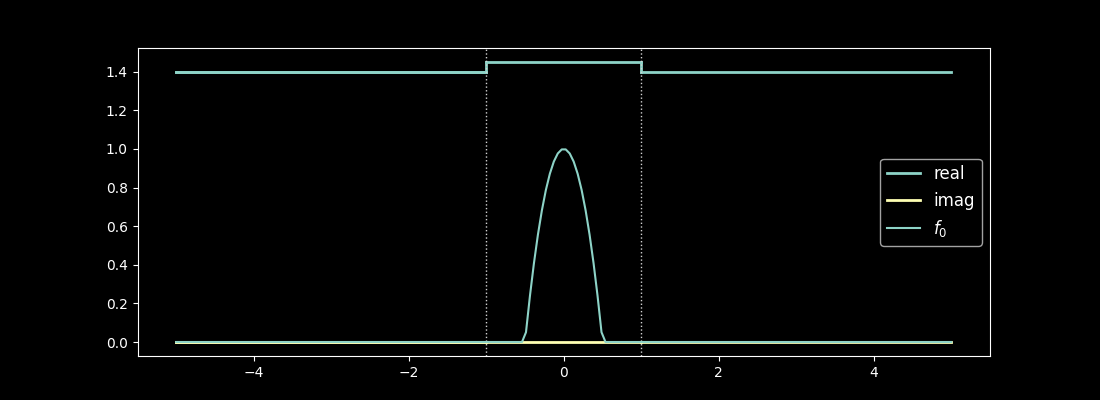

In [5]:
A.plot_refractive_index(color='cornflowerblue', linewidth=2);
A.add_1d_plot(lambda x: f0(x), label='$f_0$')

# Propagate Radiation Field

In [6]:
Propagator_Class = A.propagator()
Eig = A.normalizer('eigvec')

### Propagating Portion

This part takes a lot of resolution in this case.  Spike locations are near leaky modes

#### Spike 1

In [7]:
P_prop1e = Propagator_Class(A.real_contour(0.00001, A.Z_evanescent, 400), f0=f0, Lx=-b, Rx=b, 
                     field_type=field_type, Normalizer=Eig,
                     sign='+1')
P_prop1o = Propagator_Class(A.real_contour(0.00001, A.Z_evanescent, 400), f0=f0, Lx=-b, Rx=b, 
                     field_type=field_type, Normalizer=Eig,
                     sign='-1')

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

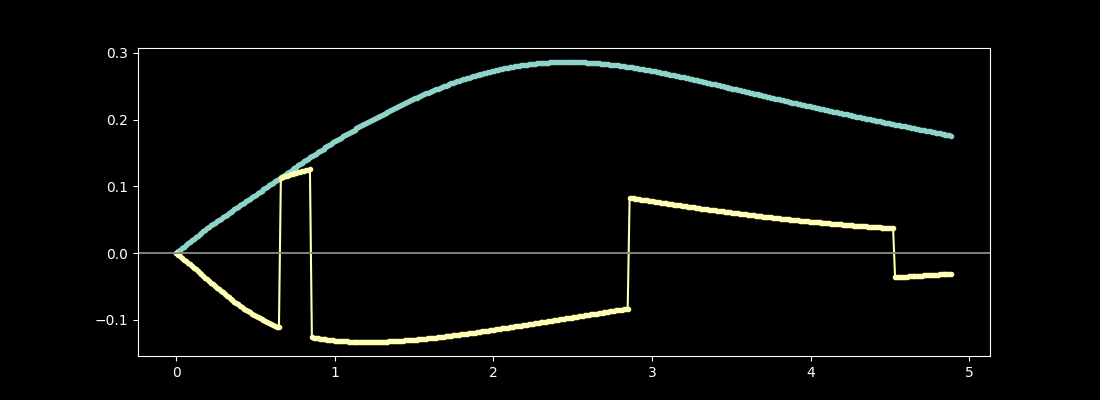

In [8]:
P_prop1e.plot_transform()
P_prop1o.plot_transform(ax=plt.gca())

### Evanescent Portion

In [9]:
P_ev1e = Propagator_Class(A.real_contour(A.Z_evanescent, 60, 700), f0=f0, Lx=-b, Rx=b, 
                     field_type=field_type, Normalizer=Eig,
                     sign='+1')
P_ev1o = Propagator_Class(A.real_contour(A.Z_evanescent, 60, 700), f0=f0, Lx=-b, Rx=b, 
                     field_type=field_type, Normalizer=Eig,
                     sign='-1')

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

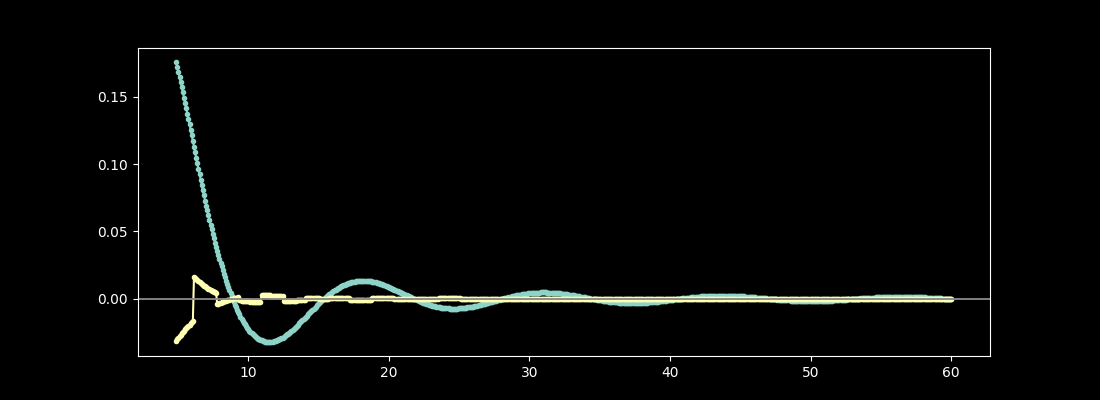

In [10]:
P_ev1e.plot_transform()
P_ev1o.plot_transform(ax=plt.gca())

In [11]:
propfuncs = [
    P_prop1e,
    P_prop1o,
]

evfuncs = [
    P_ev1e, 
    P_ev1o,
]

# Cross sections at input


In [12]:
prop = lambda x: sum([f.slice_propagate(x) for f in propfuncs])
ev = lambda x: sum([f.slice_propagate(x) for f in evfuncs]) 
full = lambda x: prop(x) + ev(x)
ratio = lambda x: full(x) / f0(x)

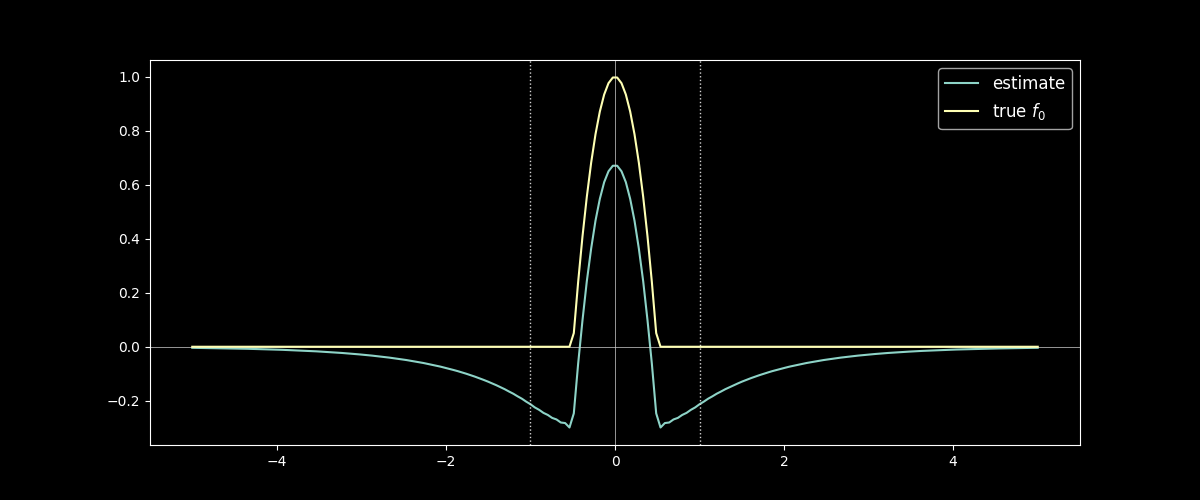

In [13]:
A.plot_field_1d(full, label='estimate') 
A.add_1d_plot(f0, label='true $f_0$')
# A.add_1d_plot(ratio, label='true $f_0$')
# plt.gca().set_xlim(-3,3)

# 2D Filled Contour Plots

In [75]:
Prop = lambda x, z: sum([f.propagate(x, zs=z) for f in propfuncs])
Ev = lambda x, z: sum([f.propagate(x, zs=z) for f in evfuncs]) 
Full = lambda x, z: Prop(x, z) + Ev(x, z)

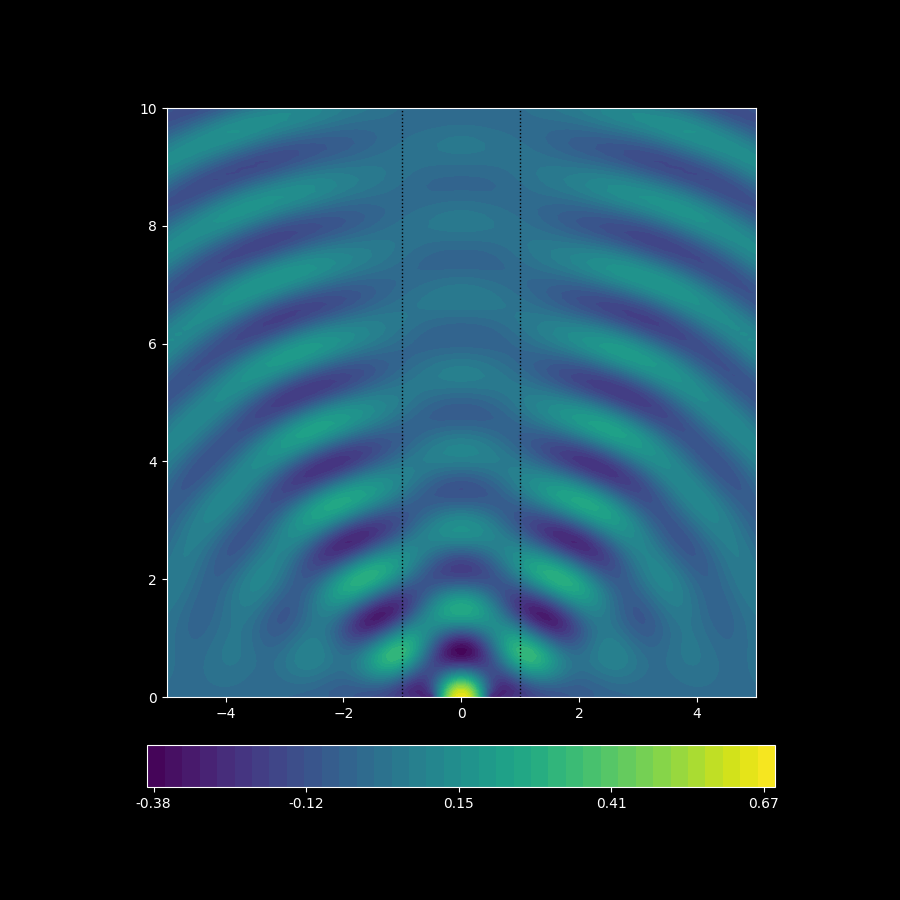

In [83]:
zmin, zmax=0, 10
A.plot_field_2d(Full, zmin=zmin, zmax=zmax, zref=int((zmax-zmin)*10));

# Surface Plot

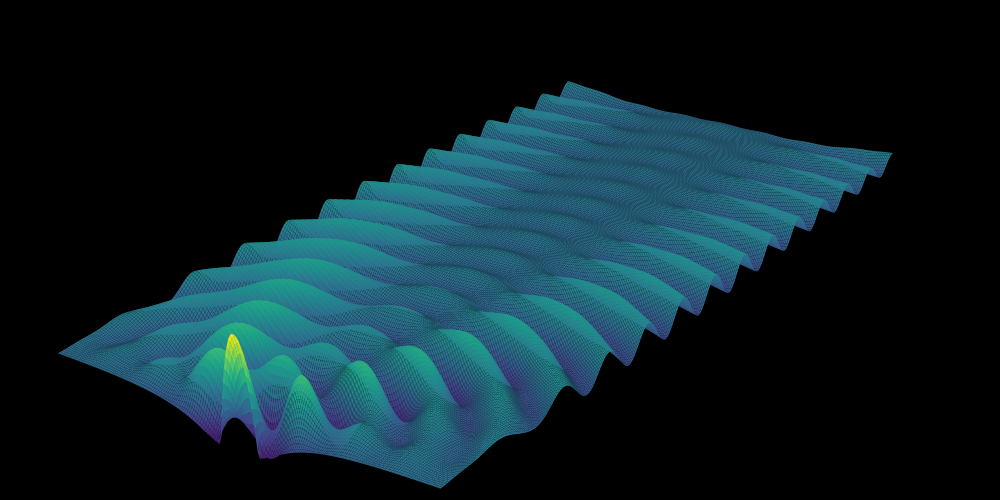

In [84]:
zmin, zmax=0, 20
A.plot_field_2d_surface(Full, colorbar=False, zoom=3, azim=-56, elev=24, zmin=0, zmax=zmax, zref=int(zmax*15),
                        rstride=1, cstride=1);

In [505]:
f0s = f0(xs)

In [506]:
rad_ys_propagating = Prop(xs, zs)


In [507]:
rad_ys_evanescent = Ev(xs, zs)


In [508]:
# guided_ys = alpha * Fs1(xs, zs=zs)

In [509]:
Xs, Zs = np.meshgrid(xs, zs)

In [510]:
def get_trig_indices(mesh_array):
    '''Get triangle index list for three js mesh formation via indexed buffer geometry.'''
    if len(mesh_array.shape) <= 1:
        raise ValueError('Provide meshgrid array as input.')
    Nz, Nx = mesh_array.shape[0], mesh_array.shape[1]
    l_inds = Nx * Nz
    indices =  np.arange(0, l_inds).reshape((Nx, Nz)).T  # Note transpose
    fbases = indices[:Nz-1, :Nx-1].T.flatten()  # Note transpose and index switch due to transpose
    f1 = np.array([[i, i+Nz, i+1] for i in fbases], dtype=int)
    f2 = np.array([[i+1, i+Nz, i+Nz+1] for i in fbases], dtype=int)
    return np.concatenate((f1, f2))


def get_base_vertices(Xs, Zs):
    '''Get vertices of triangles with zero height (y component in three.js).'''
    if Xs.shape != Zs.shape:
        raise ValueError('Provide meshgrid arrays (ie Xs, Zs = np.meshgrid(xs,zs)) as inputs.')
    Base = np.array([Xs, np.zeros_like(Xs), Zs], dtype=float)
    L = Xs.shape[0] * Xs.shape[1]
    base_vertices = Base.T.reshape((L,3))
    return base_vertices


def create_height_array_from_complex(ys, Xs):
    '''Get data for height from complex ys input (needs to be formatted as list:
        [ys[0].real, ys[0].imag, ys[1].real, ys[1].imag, ... ].'''
    L = Xs.shape[0] * Xs.shape[1]
    Ys = np.array([ys.real, ys.imag], dtype=float)
    heights = Ys.T.reshape((L,2))
    return heights


def save_trig_indices_as_json(filepath, mesh_array):
    indices = get_trig_indices(mesh_array)
    with open(filepath + '.json', 'w') as outfile:
        json.dump(indices.flatten().tolist(), outfile, separators=(',', ':'),
                  sort_keys=True, indent=4)


def save_base_vertices_as_json(filepath, Xs, Zs):
    base_vertices = get_base_vertices(Xs, Zs)
    with open(filepath + '.json', 'w') as outfile:
        json.dump(base_vertices.flatten().tolist(), outfile, separators=(',', ':'),
                  sort_keys=True, indent=4)
        

def save_heights_as_json(filepath, ys, Xs):
    heights= create_height_array_from_complex(ys, Xs)
    with open(filepath + '.json', 'w') as outfile:
        json.dump(heights.flatten().tolist(), outfile, separators=(',', ':'),
                  sort_keys=True, indent=4)

def save_values_as_json(filepath, f0s):
    with open(filepath + '.json', 'w') as outfile:
        json.dump(f0s.tolist(), outfile, separators=(',', ':'),
                  sort_keys=True, indent=4)


In [511]:
prefix='/home/pv/local/slab/apps/hollow_core/'

In [512]:
save_trig_indices_as_json(prefix + 'trig_indices_new', Xs)

In [513]:
save_base_vertices_as_json(prefix + 'base_vertices_new', Xs, Zs)

In [514]:
# save_heights_as_json(prefix + 'guided_heights', guided_ys, Xs)

In [515]:
save_heights_as_json(prefix + 'evanescent_heights', rad_ys_evanescent, Xs)

In [516]:
save_heights_as_json(prefix + 'propagating_heights', rad_ys_propagating, Xs)

In [517]:
save_values_as_json(prefix + 'f0s', f0s)

In [518]:
save_values_as_json(prefix + 'x0s', xs)

In [18]:
mode_type = 'leaky'
k_low = A.K_low

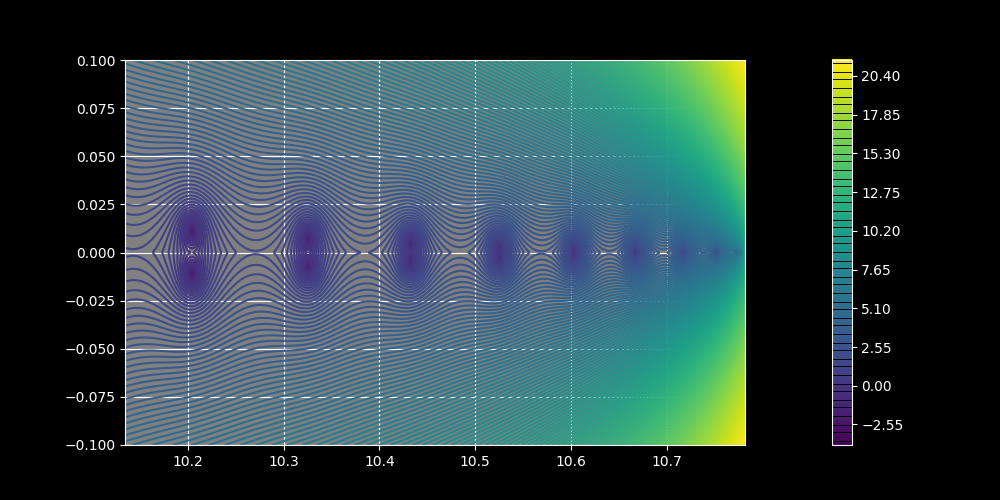

In [19]:
plotlogf(A.determinant, .94*A.K_low, 1.0001*A.K_low, -.1, .1, field_type, mode_type, 
         figsize=(10,5),iref=400, rref=400, levels=200)

### Only even modes necessary

In [20]:
beta1 = newton(A.determinant, 10.775, args=(field_type, mode_type)).conj()
beta2 = newton(A.determinant, 10.715, args=(field_type, mode_type))
beta3 = newton(A.determinant, 10.6, args=(field_type, mode_type))
beta4 = newton(A.determinant, 10.42, args=(field_type, mode_type))
beta5 = newton(A.determinant, 10.2, args=(field_type, mode_type))

betas = [beta1, beta2, beta3, beta4, beta5]
for beta in betas:
    plt.plot(beta.real, beta.imag, marker='o')


In [21]:
Fs1 = A.fields(beta1, field_type=field_type, mode_type=mode_type, c0=-1)
Fs2 = A.fields(beta2, field_type=field_type, mode_type=mode_type, c0=-1)
Fs3 = A.fields(beta3, field_type=field_type, mode_type=mode_type, c0=-1)
Fs4 = A.fields(beta4, field_type=field_type, mode_type=mode_type, c0=-1)
Fs5 = A.fields(beta5, field_type=field_type, mode_type=mode_type, c0=-1)

Fs = [Fs1, Fs2, Fs3, Fs4, Fs5]

leaky
leaky
leaky
leaky
leaky


/home/pv/local/slab/slab.py:535: UserWarning: Provided mode type leaky, but coefficients in outer region do not align with this. User may wish to check supplied propagation constant and/or rounding parameter.
  warn(message='Provided mode type %s, but coefficients in outer \


### Plotting leaky modes

#### 1D plots

/home/pv/local/slab/slab.py:1525: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=legend_fontsize)
/home/pv/local/slab/slab.py:1589: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=legend_fontsize)


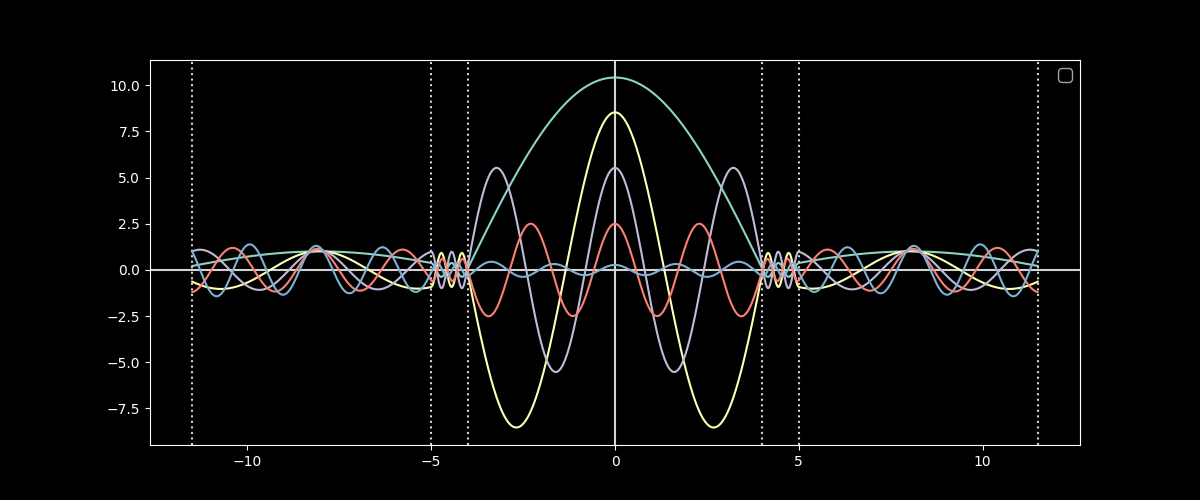

In [22]:
A.plot_field_1d(Fs1)
A.add_1d_plot(Fs2)
A.add_1d_plot(Fs3)
A.add_1d_plot(Fs4)
A.add_1d_plot(Fs5)


### Build "full" leaky field

At this point this is just to get an idea of combining leaky modes.  Scaling should be done via contour integration.

In [23]:
from scipy.integrate import quad
cfs = np.zeros(len(Fs))
alphas = np.zeros(len(Fs))
for i,F in enumerate(Fs):
    integrand = lambda x: F(x) * F(x).conjugate()
    cfs[i] = quad(integrand, A.Rhos[2], A.Rhos[3], complex_func=True)[0].real
    integrand = lambda x: f0(x) * F(x).conjugate()
    alphas[i] = quad(integrand, A.Rhos[2], A.Rhos[3], complex_func=True)[0].real

# Note: Not clear that this is correct process for scaling leaky fields

In [24]:
Full_leaky = lambda x, z: sum([Fs[i](x,z) * alphas[i]/cfs[i] for i in range(len(Fs))])

### 2D plots

In [25]:
xs = np.linspace(-20,20,1000)

(-20.0, 20.0, 0.0, 100.0)

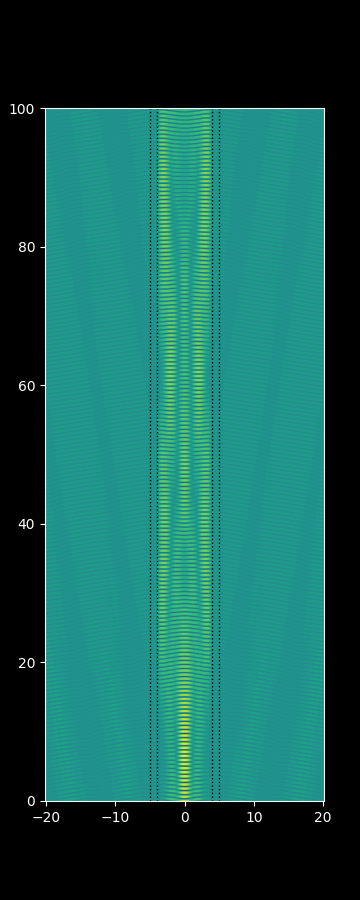

In [26]:
fig, ax = A.plot_field_2d(Full_leaky, xs=xs, zmin=0, zmax=100, zref=2000, colorbar=False)
plt.axis('equal')